In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t
import warnings

# Simulation for 2 bonds

## Multivariate Gaussian

Independent VAR at 99% confidence level: -28.515836000000007
Dependent VAR at 99% confidence level: -32.435835999999995


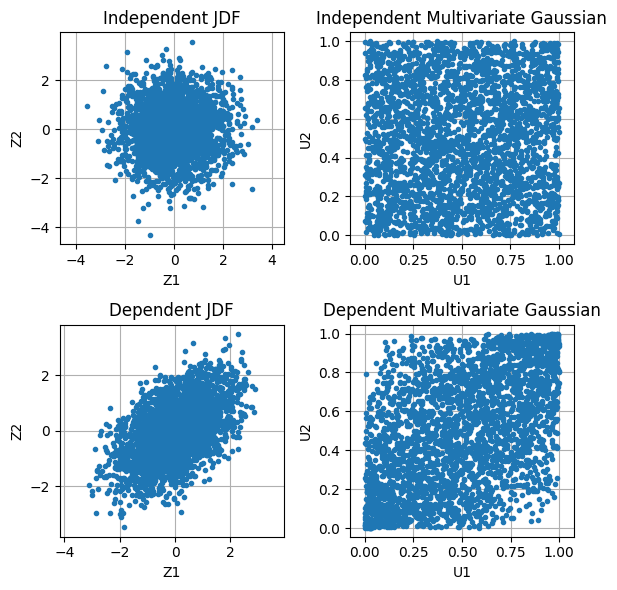

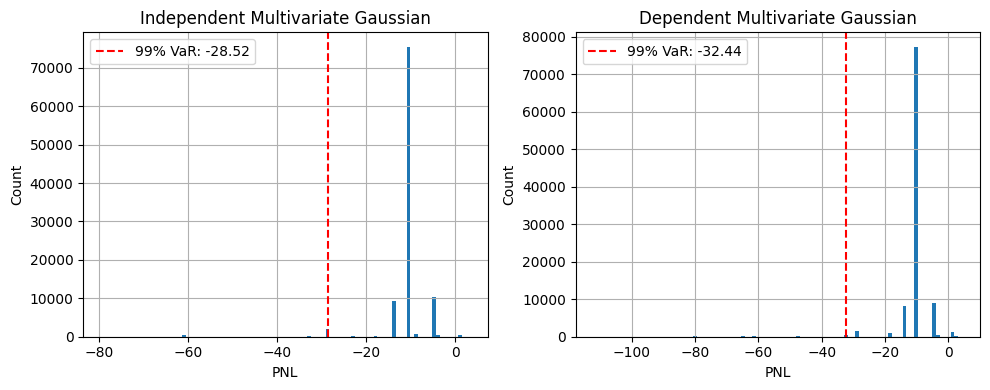

In [22]:
# Bond Ratings
BondRating = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "Default"]

# Probabilities (divided by 100 to convert percentages to decimals)
Probability = np.array([0.02, 0.33, 5.95, 86.93, 5.30, 1.17, 0.12, 0.18]) / 100

# Cumulative probabilities in reverse order
CumProbability = np.cumsum(Probability[::-1])[::-1]

# Bond Values
BondValue = np.array([109.37, 109.19, 108.66, 107.55, 102.02, 98.10, 83.64, 51.13])

# Create DataFrame
TblBond = pd.DataFrame({
    'Rating': BondRating,
    'Probability': Probability,
    'CumProbability': CumProbability,
    'TransitionValue': BondValue
})

# Define the Marginal Distribution as N(0,1)
ZBoundary = norm.ppf(CumProbability)

# Add ZBoundaries to TblBond
TblBond['Z'] = ZBoundary

# Simulation parameters
N = 100000  # Number of simulations
DefaultRho = 0.5  # Default correlation

# Number of bonds
NBonds = 2

# Correlation matrices
# For independent case
CIND = np.eye(NBonds)

# For dependent case
CDEP = DefaultRho * np.ones((NBonds, NBonds)) + (1 - DefaultRho) * np.eye(NBonds)

# Generate standard normal samples for Independent case
Z_IND = np.random.randn(N, NBonds)
# Compute UIND
UIND = norm.cdf(Z_IND)

# Generate multivariate normal samples for Dependent case
mean = np.zeros(NBonds)
Z_DEP = np.random.multivariate_normal(mean, CDEP, size=N)
# Compute UDEP
UDEP = norm.cdf(Z_DEP)

# Now that we have the samples of U, we can estimate the probability of default

# Compute current value of a bond
CurrentValueBond = np.dot(Probability, BondValue)
CurrentValuePortfolio = CurrentValueBond * NBonds

# Create cumulative probability boundaries
CumProbabilityBoundary = np.append(CumProbability, 0)

# Prepare arrays for future bond values
FutureBondValueIND = np.zeros((N, NBonds))
FutureBondValueDEP = np.zeros((N, NBonds))

# Mapping U values to bond values using a for loop
for i in range(N):
    # Independent Example
    for j in range(NBonds):
        U_value = UIND[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)  # Ensure index is within bounds
        FutureBondValueIND[i, j] = BondValue[IZ]

    # Dependent Example
    for j in range(NBonds):
        U_value = UDEP[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)
        FutureBondValueDEP[i, j] = BondValue[IZ]

# Portfolio PNL
PortfolioIND = np.sum(FutureBondValueIND, axis=1) - CurrentValuePortfolio
PortfolioDEP = np.sum(FutureBondValueDEP, axis=1) - CurrentValuePortfolio

# 99% Loss Estimates (1st percentile)
INDVAR99 = np.percentile(PortfolioIND, 1)
DEPVAR99 = np.percentile(PortfolioDEP, 1)

print(f"Independent VAR at 99% confidence level: {INDVAR99}")
print(f"Dependent VAR at 99% confidence level: {DEPVAR99}")

# Sample indices for plotting
ISample = np.arange(3000)

# Plotting
plt.figure(figsize=(6,6))

plt.subplot(2,2,1)
plt.plot(Z_IND[ISample,0], Z_IND[ISample,1], '.')
plt.axis([-3, 3, -3, 3])
plt.axis('equal')
plt.grid(True)
plt.title('Independent JDF')
plt.xlabel('Z1')
plt.ylabel('Z2')

plt.subplot(2,2,2)
plt.plot(UIND[ISample,0], UIND[ISample,1], '.')
plt.axis([0, 1, 0, 1])
plt.axis('equal')
plt.grid(True)
plt.title('Independent Multivariate Gaussian')
plt.xlabel('U1')
plt.ylabel('U2')

plt.subplot(2,2,3)
plt.plot(Z_DEP[ISample,0], Z_DEP[ISample,1], '.')
plt.axis([-3, 3, -3, 3])
plt.axis('equal')
plt.grid(True)
plt.title('Dependent JDF')
plt.xlabel('Z1')
plt.ylabel('Z2')

plt.subplot(2,2,4)
plt.plot(UDEP[ISample,0], UDEP[ISample,1], '.')
plt.axis([0, 1, 0, 1])
plt.axis('equal')
plt.grid(True)
plt.title('Dependent Multivariate Gaussian')
plt.xlabel('U1')
plt.ylabel('U2')

plt.tight_layout()
plt.show()

# Plot histograms of Portfolio PNL
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(PortfolioIND, bins=100)
plt.axvline(INDVAR99, color='r', linestyle='--', label=f'99% VaR: {INDVAR99:.2f}')
plt.title('Independent Multivariate Gaussian')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(PortfolioDEP, bins=100)
plt.axvline(DEPVAR99, color='r', linestyle='--', label=f'99% VaR: {DEPVAR99:.2f}')
plt.title('Dependent Multivariate Gaussian')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Copula

Independent VAR at 99.9% confidence level: -79.405836
Dependent VAR at 99.9% confidence level: -111.915836


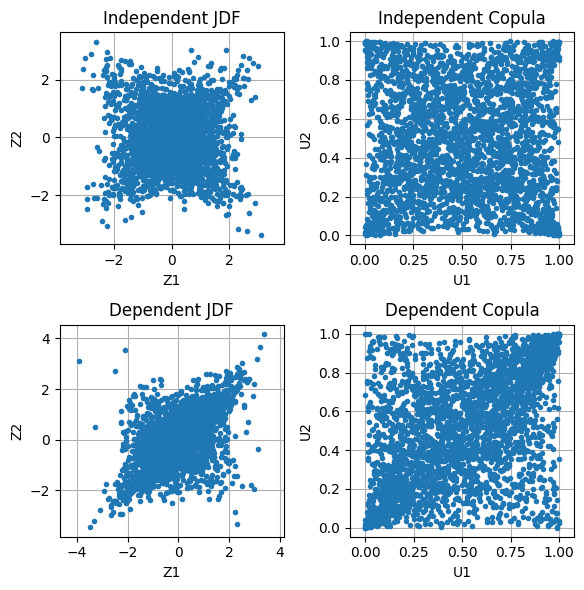

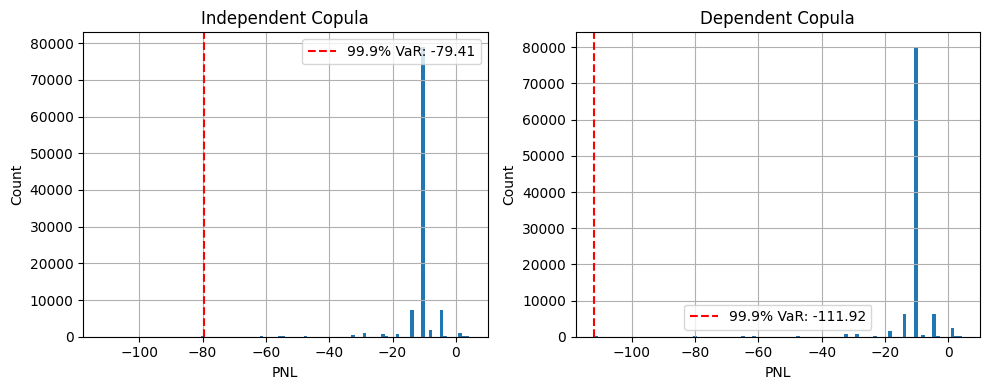

In [18]:
# Bond Ratings
BondRating = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "Default"]

# Probabilities (divided by 100 to convert percentages to decimals)
Probability = np.array([0.02, 0.33, 5.95, 86.93, 5.30, 1.17, 0.12, 0.18]) / 100

# Cumulative probabilities in reverse order
CumProbability = np.cumsum(Probability[::-1])[::-1]

# Bond Values
BondValue = np.array([109.37, 109.19, 108.66, 107.55, 102.02, 98.10, 83.64, 51.13])

# Create DataFrame
TblBond = pd.DataFrame({
    'Rating': BondRating,
    'Probability': Probability,
    'CumProbability': CumProbability,
    'TransitionValue': BondValue
})

# Define the Marginal Distribution as N(0,1)
ZDefault = norm.ppf(TblBond['Probability'][7], loc=0, scale=1)
ZC = norm.ppf(TblBond['Probability'][6:].sum(), loc=0, scale=1)
ZB = norm.ppf(TblBond['Probability'][5:].sum(), loc=0, scale=1)
ZBB = norm.ppf(TblBond['Probability'][4:].sum(), loc=0, scale=1)
ZBBB = norm.ppf(TblBond['Probability'][3:].sum(), loc=0, scale=1)
ZA = norm.ppf(TblBond['Probability'][2:].sum(), loc=0, scale=1)
ZAA = norm.ppf(TblBond['Probability'][1:].sum(), loc=0, scale=1)
ZAAA = norm.ppf(TblBond['Probability'][0:].sum(), loc=0, scale=1)

ZBoundary = np.array([ZAAA, ZAA, ZA, ZBBB, ZBB, ZB, ZC, ZDefault])

# Add ZBoundaries to TblBond
TblBond['Z'] = ZBoundary

# Simulation parameters
N = 100000  # Number of simulations
DefaultRho = 0.5  # Default correlation

# Number of bonds
NBonds = 2

# Correlation matrices
# For independent case
CIND = np.eye(NBonds)

# For dependent case
CDEP = DefaultRho * np.ones((NBonds, NBonds)) + (1 - DefaultRho) * np.eye(NBonds)

# Degrees of freedom for t-distribution
nu = 2

# Generate t-distributed samples for Independent case
Z_IND = np.random.randn(N, NBonds)
W_IND = np.random.chisquare(nu, N) / nu
X_IND = Z_IND / np.sqrt(W_IND)[:, None]
# Compute UIND
UIND = t.cdf(X_IND, df=nu)

# Generate t-distributed samples for Dependent case
L_DEP = np.linalg.cholesky(CDEP)
Z_DEP = np.random.randn(N, NBonds) @ L_DEP.T
W_DEP = np.random.chisquare(nu, N) / nu
X_DEP = Z_DEP / np.sqrt(W_DEP)[:, None]
# Compute UDEP
UDEP = t.cdf(X_DEP, df=nu)

# Now that we have the samples of U, we can estimate the probability of default

# Compute current value of a bond
CurrentValueBond = np.dot(Probability, BondValue)
CurrentValuePortfolio = CurrentValueBond * NBonds

# Create cumulative probability boundaries
CumProbabilityBoundary = np.append(CumProbability, 0)

# Prepare arrays for future bond values
FutureBondValueIND = np.zeros((N, NBonds))
FutureBondValueDEP = np.zeros((N, NBonds))

# Mapping U values to bond values using a for loop
for i in range(N):
    # Independent Example
    for j in range(NBonds):
        U_value = UIND[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)  # Ensure index is within bounds
        FutureBondValueIND[i, j] = BondValue[IZ]

    # Dependent Example
    for j in range(NBonds):
        U_value = UDEP[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)
        FutureBondValueDEP[i, j] = BondValue[IZ]

# Portfolio PNL
PortfolioIND = np.sum(FutureBondValueIND, axis=1) - CurrentValuePortfolio
PortfolioDEP = np.sum(FutureBondValueDEP, axis=1) - CurrentValuePortfolio

# 99.9% Loss Estimates (0.1 percentile)
INDVAR99 = np.percentile(PortfolioIND, 0.1)
DEPVAR99 = np.percentile(PortfolioDEP, 0.1)

print(f"Independent VAR at 99.9% confidence level: {INDVAR99}")
print(f"Dependent VAR at 99.9% confidence level: {DEPVAR99}")

# Sample indices for plotting
ISample = np.arange(3000)

# Plotting
plt.figure(figsize=(6,6))

plt.subplot(2,2,1)
plt.plot(norm.ppf(UIND[ISample,0]), norm.ppf(UIND[ISample,1]), '.')
plt.axis([-3, 3, -3, 3])
plt.axis('equal')
plt.grid(True)
plt.title('Independent JDF')
plt.xlabel('Z1')
plt.ylabel('Z2')

plt.subplot(2,2,2)
plt.plot(UIND[ISample,0], UIND[ISample,1], '.')
plt.axis([0, 1, 0, 1])
plt.axis('equal')
plt.grid(True)
plt.title('Independent Copula')
plt.xlabel('U1')
plt.ylabel('U2')

plt.subplot(2,2,3)
plt.plot(norm.ppf(UDEP[ISample,0]), norm.ppf(UDEP[ISample,1]), '.')
plt.axis([-3, 3, -3, 3])
plt.axis('equal')
plt.grid(True)
plt.title('Dependent JDF')
plt.xlabel('Z1')
plt.ylabel('Z2')

plt.subplot(2,2,4)
plt.plot(UDEP[ISample,0], UDEP[ISample,1], '.')
plt.axis([0, 1, 0, 1])
plt.axis('equal')
plt.grid(True)
plt.title('Dependent Copula')
plt.xlabel('U1')
plt.ylabel('U2')

plt.tight_layout()
plt.show()

# Plot histograms of Portfolio PNL
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(PortfolioIND, bins=100)
plt.axvline(INDVAR99, color='r', linestyle='--', label=f'99.9% VaR: {INDVAR99:.2f}')
plt.title('Independent Copula')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(PortfolioDEP, bins=100)
plt.axvline(DEPVAR99, color='r', linestyle='--', label=f'99.9% VaR: {DEPVAR99:.2f}')
plt.title('Dependent Copula')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Simulation for 10 bonds

## Multivariate Gaussian

Independent VAR at 99% confidence level: -103.8791799999999
Dependent VAR at 99% confidence level: -135.95917999999995


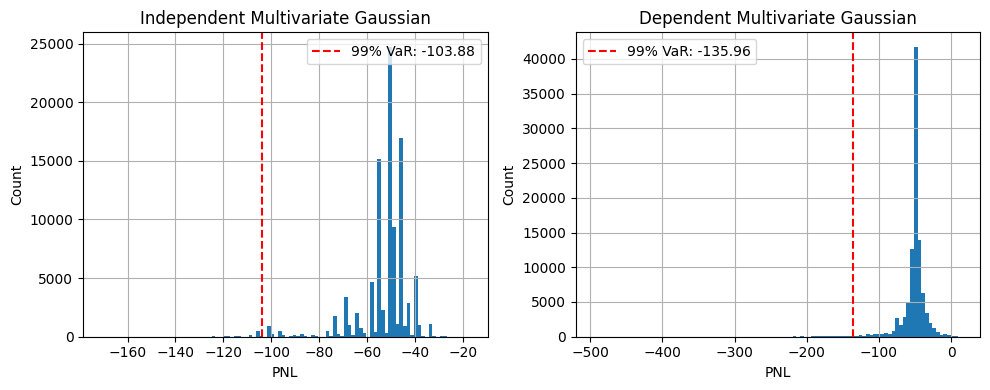

In [23]:
# Bond Ratings
BondRating = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "Default"]

# Probabilities (divided by 100 to convert percentages to decimals)
Probability = np.array([0.02, 0.33, 5.95, 86.93, 5.30, 1.17, 0.12, 0.18]) / 100

# Cumulative probabilities in reverse order
CumProbability = np.cumsum(Probability[::-1])[::-1]

# Bond Values
BondValue = np.array([109.37, 109.19, 108.66, 107.55, 102.02, 98.10, 83.64, 51.13])

# Create DataFrame
TblBond = pd.DataFrame({
    'Rating': BondRating,
    'Probability': Probability,
    'CumProbability': CumProbability,
    'TransitionValue': BondValue
})

# Define the Marginal Distribution as N(0,1)
ZBoundary = norm.ppf(CumProbability)

# Add ZBoundaries to TblBond
TblBond['Z'] = ZBoundary

# Simulation parameters
N = 100000  # Number of simulations
DefaultRho = 0.5  # Default correlation

# Number of bonds
NBonds = 10

# Correlation matrices
# For independent case
CIND = np.eye(NBonds)

# For dependent case
CDEP = DefaultRho * np.ones((NBonds, NBonds)) + (1 - DefaultRho) * np.eye(NBonds)

# Generate standard normal samples for Independent case
Z_IND = np.random.randn(N, NBonds)
# Compute UIND
UIND = norm.cdf(Z_IND)

# Generate multivariate normal samples for Dependent case
mean = np.zeros(NBonds)
Z_DEP = np.random.multivariate_normal(mean, CDEP, size=N)
# Compute UDEP
UDEP = norm.cdf(Z_DEP)

# Now that we have the samples of U, we can estimate the probability of default

# Compute current value of a bond
CurrentValueBond = np.dot(Probability, BondValue)
CurrentValuePortfolio = CurrentValueBond * NBonds

# Create cumulative probability boundaries
CumProbabilityBoundary = np.append(CumProbability, 0)

# Prepare arrays for future bond values
FutureBondValueIND = np.zeros((N, NBonds))
FutureBondValueDEP = np.zeros((N, NBonds))

# Mapping U values to bond values using a for loop
for i in range(N):
    # Independent Example
    for j in range(NBonds):
        U_value = UIND[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)  # Ensure index is within bounds
        FutureBondValueIND[i, j] = BondValue[IZ]

    # Dependent Example
    for j in range(NBonds):
        U_value = UDEP[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)
        FutureBondValueDEP[i, j] = BondValue[IZ]

# Portfolio PNL
PortfolioIND = np.sum(FutureBondValueIND, axis=1) - CurrentValuePortfolio
PortfolioDEP = np.sum(FutureBondValueDEP, axis=1) - CurrentValuePortfolio

# 99% Loss Estimates (1st percentile)
INDVAR99 = np.percentile(PortfolioIND, 1)
DEPVAR99 = np.percentile(PortfolioDEP, 1)

print(f"Independent VAR at 99% confidence level: {INDVAR99}")
print(f"Dependent VAR at 99% confidence level: {DEPVAR99}")

# Plot histograms of Portfolio PNL
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(PortfolioIND, bins=100)
plt.axvline(INDVAR99, color='r', linestyle='--', label=f'99% VaR: {INDVAR99:.2f}')
plt.title('Independent Multivariate Gaussian')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(PortfolioDEP, bins=100)
plt.axvline(DEPVAR99, color='r', linestyle='--', label=f'99% VaR: {DEPVAR99:.2f}')
plt.title('Dependent Multivariate Gaussian')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Copula

Independent VAR at 99.9% confidence level: -260.44926999999984
Dependent VAR at 99.9% confidence level: -405.6291799999999


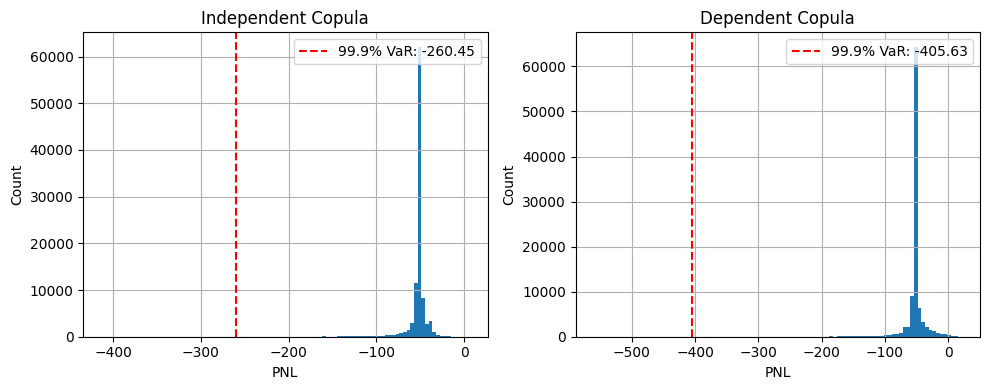

In [17]:
# Bond Ratings
BondRating = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "Default"]

# Probabilities (divided by 100 to convert percentages to decimals)
Probability = np.array([0.02, 0.33, 5.95, 86.93, 5.30, 1.17, 0.12, 0.18]) / 100

# Cumulative probabilities in reverse order
CumProbability = np.cumsum(Probability[::-1])[::-1]

# Bond Values
BondValue = np.array([109.37, 109.19, 108.66, 107.55, 102.02, 98.10, 83.64, 51.13])

# Create DataFrame
TblBond = pd.DataFrame({
    'Rating': BondRating,
    'Probability': Probability,
    'CumProbability': CumProbability,
    'TransitionValue': BondValue
})

# Define the Marginal Distribution as N(0,1)
ZDefault = norm.ppf(TblBond['Probability'][7], loc=0, scale=1)
ZC = norm.ppf(TblBond['Probability'][6:].sum(), loc=0, scale=1)
ZB = norm.ppf(TblBond['Probability'][5:].sum(), loc=0, scale=1)
ZBB = norm.ppf(TblBond['Probability'][4:].sum(), loc=0, scale=1)
ZBBB = norm.ppf(TblBond['Probability'][3:].sum(), loc=0, scale=1)
ZA = norm.ppf(TblBond['Probability'][2:].sum(), loc=0, scale=1)
ZAA = norm.ppf(TblBond['Probability'][1:].sum(), loc=0, scale=1)
ZAAA = norm.ppf(TblBond['Probability'][0:].sum(), loc=0, scale=1)

ZBoundary = np.array([ZAAA, ZAA, ZA, ZBBB, ZBB, ZB, ZC, ZDefault])

# Add ZBoundaries to TblBond
TblBond['Z'] = ZBoundary

# Simulation parameters
N = 100000  # Number of simulations
DefaultRho = 0.5  # Default correlation

# Number of bonds
NBonds = 10

# Correlation matrices
# For independent case
CIND = np.eye(NBonds)

# For dependent case
CDEP = DefaultRho * np.ones((NBonds, NBonds)) + (1 - DefaultRho) * np.eye(NBonds)

# Degrees of freedom for t-distribution
nu = 2

# Generate t-distributed samples for Independent case
Z_IND = np.random.randn(N, NBonds)
W_IND = np.random.chisquare(nu, N) / nu
X_IND = Z_IND / np.sqrt(W_IND)[:, None]
# Compute UIND
UIND = t.cdf(X_IND, df=nu)

# Generate t-distributed samples for Dependent case
L_DEP = np.linalg.cholesky(CDEP)
Z_DEP = np.random.randn(N, NBonds) @ L_DEP.T
W_DEP = np.random.chisquare(nu, N) / nu
X_DEP = Z_DEP / np.sqrt(W_DEP)[:, None]
# Compute UDEP
UDEP = t.cdf(X_DEP, df=nu)

# Compute current value of a bond
CurrentValueBond = np.dot(Probability, BondValue)
CurrentValuePortfolio = CurrentValueBond * NBonds

# Create cumulative probability boundaries
CumProbabilityBoundary = np.append(CumProbability, 0)

# Prepare arrays for future bond values
FutureBondValueIND = np.zeros((N, NBonds))
FutureBondValueDEP = np.zeros((N, NBonds))

# Mapping U values to bond values using a for loop
for i in range(N):
    # Independent Example
    for j in range(NBonds):
        U_value = UIND[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)  # Ensure index is within bounds
        FutureBondValueIND[i, j] = BondValue[IZ]

    # Dependent Example
    for j in range(NBonds):
        U_value = UDEP[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)
        FutureBondValueDEP[i, j] = BondValue[IZ]

# Portfolio PNL
PortfolioIND = np.sum(FutureBondValueIND, axis=1) - CurrentValuePortfolio
PortfolioDEP = np.sum(FutureBondValueDEP, axis=1) - CurrentValuePortfolio

# 99.9% Loss Estimates (0.1 percentile)
INDVAR99 = np.percentile(PortfolioIND, 0.1)
DEPVAR99 = np.percentile(PortfolioDEP, 0.1)

print(f"Independent VAR at 99.9% confidence level: {INDVAR99}")
print(f"Dependent VAR at 99.9% confidence level: {DEPVAR99}")

# Plot histograms of Portfolio PNL
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(PortfolioIND, bins=100)
plt.axvline(INDVAR99, color='r', linestyle='--', label=f'99.9% VaR: {INDVAR99:.2f}')
plt.title('Independent Copula')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(PortfolioDEP, bins=100)
plt.axvline(DEPVAR99, color='r', linestyle='--', label=f'99.9% VaR: {DEPVAR99:.2f}')
plt.title('Dependent Copula')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Simulation for 100 bonds

## Multivariate Gaussian

Independent VAR at 99% confidence level: -638.131800000001
Dependent VAR at 99% confidence level: -1282.5484000000026


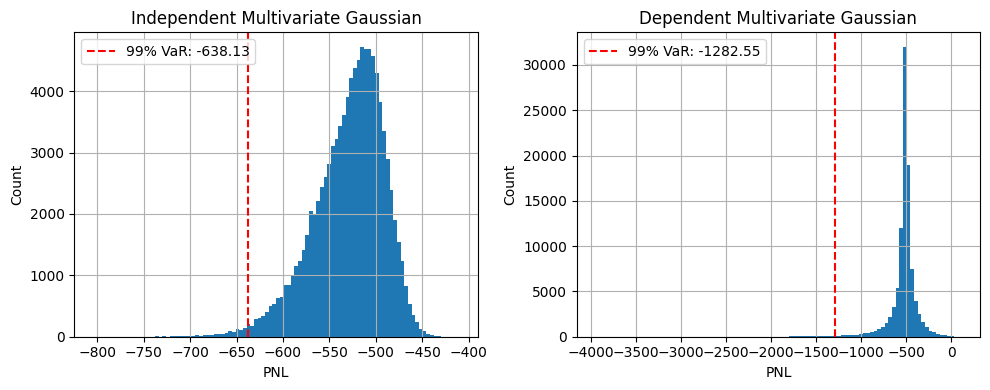

In [24]:
# Bond Values
BondValue = np.array([109.37, 109.19, 108.66, 107.55, 102.02, 98.10, 83.64, 51.13])

# Create DataFrame
TblBond = pd.DataFrame({
    'Rating': BondRating,
    'Probability': Probability,
    'CumProbability': CumProbability,
    'TransitionValue': BondValue
})

# Define the Marginal Distribution as N(0,1)
ZBoundary = norm.ppf(CumProbability)

# Add ZBoundaries to TblBond
TblBond['Z'] = ZBoundary

# Simulation parameters
N = 100000  # Number of simulations
DefaultRho = 0.5  # Default correlation

# Number of bonds
NBonds = 100

# Correlation matrices
# For independent case
CIND = np.eye(NBonds)

# For dependent case
CDEP = DefaultRho * np.ones((NBonds, NBonds)) + (1 - DefaultRho) * np.eye(NBonds)

# Generate standard normal samples for Independent case
Z_IND = np.random.randn(N, NBonds)
# Compute UIND
UIND = norm.cdf(Z_IND)

# Generate multivariate normal samples for Dependent case
mean = np.zeros(NBonds)
Z_DEP = np.random.multivariate_normal(mean, CDEP, size=N)
# Compute UDEP
UDEP = norm.cdf(Z_DEP)

# Now that we have the samples of U, we can estimate the probability of default

# Compute current value of a bond
CurrentValueBond = np.dot(Probability, BondValue)
CurrentValuePortfolio = CurrentValueBond * NBonds

# Create cumulative probability boundaries
CumProbabilityBoundary = np.append(CumProbability, 0)

# Prepare arrays for future bond values
FutureBondValueIND = np.zeros((N, NBonds))
FutureBondValueDEP = np.zeros((N, NBonds))

# Mapping U values to bond values using a for loop
for i in range(N):
    # Independent Example
    for j in range(NBonds):
        U_value = UIND[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)  # Ensure index is within bounds
        FutureBondValueIND[i, j] = BondValue[IZ]

    # Dependent Example
    for j in range(NBonds):
        U_value = UDEP[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)
        FutureBondValueDEP[i, j] = BondValue[IZ]

# Portfolio PNL
PortfolioIND = np.sum(FutureBondValueIND, axis=1) - CurrentValuePortfolio
PortfolioDEP = np.sum(FutureBondValueDEP, axis=1) - CurrentValuePortfolio

# 99% Loss Estimates (1st percentile)
INDVAR99 = np.percentile(PortfolioIND, 1)
DEPVAR99 = np.percentile(PortfolioDEP, 1)

print(f"Independent VAR at 99% confidence level: {INDVAR99}")
print(f"Dependent VAR at 99% confidence level: {DEPVAR99}")

# Plot histograms of Portfolio PNL
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(PortfolioIND, bins=100)
plt.axvline(INDVAR99, color='r', linestyle='--', label=f'99% VaR: {INDVAR99:.2f}')
plt.title('Independent Multivariate Gaussian')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(PortfolioDEP, bins=100)
plt.axvline(DEPVAR99, color='r', linestyle='--', label=f'99% VaR: {DEPVAR99:.2f}')
plt.title('Dependent Multivariate Gaussian')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Copula

Independent VAR at 99.9% confidence level: -2150.761880000002
Dependent VAR at 99.9% confidence level: -4106.852250000001


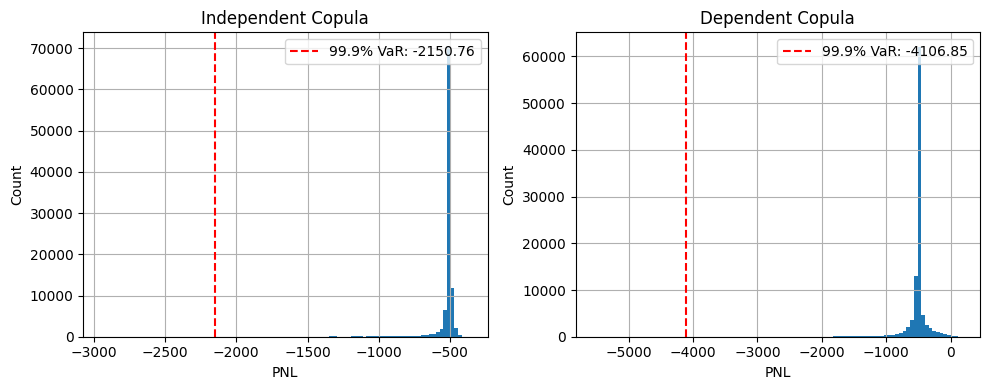

In [14]:
# Bond Ratings
BondRating = ["AAA", "AA", "A", "BBB", "BB", "B", "C", "Default"]

# Probabilities (divided by 100 to convert percentages to decimals)
Probability = np.array([0.02, 0.33, 5.95, 86.93, 5.30, 1.17, 0.12, 0.18]) / 100

# Cumulative probabilities in reverse order
CumProbability = np.cumsum(Probability[::-1])[::-1]

# Bond Values
BondValue = np.array([109.37, 109.19, 108.66, 107.55, 102.02, 98.10, 83.64, 51.13])

# Create DataFrame
TblBond = pd.DataFrame({
    'Rating': BondRating,
    'Probability': Probability,
    'CumProbability': CumProbability,
    'TransitionValue': BondValue
})

# Define the Marginal Distribution as N(0,1)
ZDefault = norm.ppf(TblBond['Probability'][7], loc=0, scale=1)
ZC = norm.ppf(TblBond['Probability'][6:].sum(), loc=0, scale=1)
ZB = norm.ppf(TblBond['Probability'][5:].sum(), loc=0, scale=1)
ZBB = norm.ppf(TblBond['Probability'][4:].sum(), loc=0, scale=1)
ZBBB = norm.ppf(TblBond['Probability'][3:].sum(), loc=0, scale=1)
ZA = norm.ppf(TblBond['Probability'][2:].sum(), loc=0, scale=1)
ZAA = norm.ppf(TblBond['Probability'][1:].sum(), loc=0, scale=1)
ZAAA = norm.ppf(TblBond['Probability'][0:].sum(), loc=0, scale=1)

ZBoundary = np.array([ZAAA, ZAA, ZA, ZBBB, ZBB, ZB, ZC, ZDefault])

# Add ZBoundaries to TblBond
TblBond['Z'] = ZBoundary

# Simulation parameters
N = 100000  # Number of simulations
DefaultRho = 0.5  # Default correlation

# Number of bonds
NBonds = 100

# Correlation matrices
# For independent case
CIND = np.eye(NBonds)

# For dependent case
CDEP = DefaultRho * np.ones((NBonds, NBonds)) + (1 - DefaultRho) * np.eye(NBonds)

# Degrees of freedom for t-distribution
nu = 2

# Generate t-distributed samples for Independent case
Z_IND = np.random.randn(N, NBonds)
W_IND = np.random.chisquare(nu, N) / nu
X_IND = Z_IND / np.sqrt(W_IND)[:, None]
# Compute UIND
UIND = t.cdf(X_IND, df=nu)

# Generate t-distributed samples for Dependent case
L_DEP = np.linalg.cholesky(CDEP)
Z_DEP = np.random.randn(N, NBonds) @ L_DEP.T
W_DEP = np.random.chisquare(nu, N) / nu
X_DEP = Z_DEP / np.sqrt(W_DEP)[:, None]
# Compute UDEP
UDEP = t.cdf(X_DEP, df=nu)

# Now that we have the samples of U, we can estimate the probability of default

# Compute current value of a bond
CurrentValueBond = np.dot(Probability, BondValue)
CurrentValuePortfolio = CurrentValueBond * NBonds

# Create cumulative probability boundaries
CumProbabilityBoundary = np.append(CumProbability, 0)

# Prepare arrays for future bond values
FutureBondValueIND = np.zeros((N, NBonds))
FutureBondValueDEP = np.zeros((N, NBonds))

# Mapping U values to bond values using a for loop
for i in range(N):
    # Independent Example
    for j in range(NBonds):
        U_value = UIND[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)  # Ensure index is within bounds
        FutureBondValueIND[i, j] = BondValue[IZ]

    # Dependent Example
    for j in range(NBonds):
        U_value = UDEP[i, j]
        # Find the first index where CumProbabilityBoundary <= U_value
        IZ = np.where(CumProbabilityBoundary <= U_value)[0][0]
        IZ = min(IZ, 7)
        FutureBondValueDEP[i, j] = BondValue[IZ]

# Portfolio PNL
PortfolioIND = np.sum(FutureBondValueIND, axis=1) - CurrentValuePortfolio
PortfolioDEP = np.sum(FutureBondValueDEP, axis=1) - CurrentValuePortfolio

# 99.9% Loss Estimates (0.1 percentile)
INDVAR99 = np.percentile(PortfolioIND, 0.1)
DEPVAR99 = np.percentile(PortfolioDEP, 0.1)

print(f"Independent VAR at 99.9% confidence level: {INDVAR99}")
print(f"Dependent VAR at 99.9% confidence level: {DEPVAR99}")

# Plot histograms of Portfolio PNL
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(PortfolioIND, bins=100)
plt.axvline(INDVAR99, color='r', linestyle='--', label=f'99.9% VaR: {INDVAR99:.2f}')
plt.title('Independent Copula')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(PortfolioDEP, bins=100)
plt.axvline(DEPVAR99, color='r', linestyle='--', label=f'99.9% VaR: {DEPVAR99:.2f}')
plt.title('Dependent Copula')
plt.ylabel('Count')
plt.xlabel('PNL')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare Multivariate Gaussian and Gaussian Copula

The Gaussian copula tends to produce higher loss predictions than the multivariate Gaussian distribution, primarily because it allows for heavier-tailed marginal distributions and better captures tail dependencies between variables. While the multivariate Gaussian distribution assumes normal marginals with light tails, resulting in a lower probability of extreme losses, the Gaussian copula separates the modeling of marginals and dependence structure. By incorporating heavy-tailed marginals (such as t-distributions), the Gaussian copula increases the likelihood of extreme individual losses. Additionally, it can model dependencies in the tails of the distribution, meaning it more accurately reflects the probability of simultaneous extreme events or defaults. This combination of heavier tails and tail dependence leads to higher loss predictions when using the Gaussian copula compared to the multivariate Gaussian distribution.

# Graph of the 99% percentile loss against the number of bonds

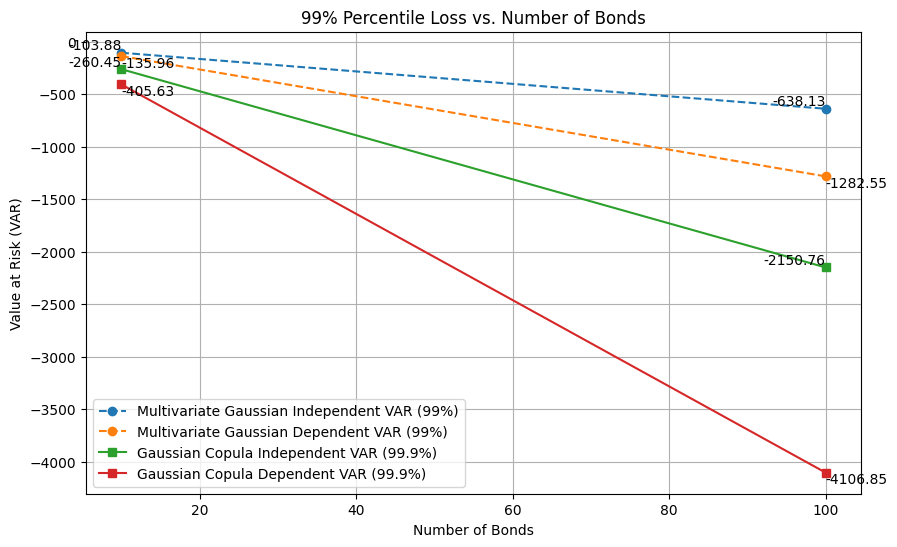

In [29]:
import matplotlib.pyplot as plt

# Data
number_of_bonds = [10, 100]

# Multivariate Gaussian Distribution at 99% confidence level
mv_gaussian_independent_var = [-103.88, -638.13]
mv_gaussian_dependent_var = [-135.96, -1282.55]

# Gaussian Copula at 99.9% confidence level
copula_independent_var = [-260.45, -2150.76]
copula_dependent_var = [-405.63, -4106.85]

# Plotting
plt.figure(figsize=(10, 6))

# Plot Multivariate Gaussian Distribution VARs
plt.plot(number_of_bonds, mv_gaussian_independent_var, 'o--', label='Multivariate Gaussian Independent VAR (99%)')
plt.plot(number_of_bonds, mv_gaussian_dependent_var, 'o--', label='Multivariate Gaussian Dependent VAR (99%)')

# Plot Gaussian Copula VARs
plt.plot(number_of_bonds, copula_independent_var, 's-', label='Gaussian Copula Independent VAR (99.9%)')
plt.plot(number_of_bonds, copula_dependent_var, 's-', label='Gaussian Copula Dependent VAR (99.9%)')

# Labels and Title
plt.xlabel('Number of Bonds')
plt.ylabel('Value at Risk (VAR)')
plt.title('99% Percentile Loss vs. Number of Bonds')
plt.legend()
plt.grid(True)

# Annotations for clarity
for x, y in zip(number_of_bonds, mv_gaussian_independent_var):
    plt.text(x, y, f"{y}", ha='right', va='bottom')
for x, y in zip(number_of_bonds, mv_gaussian_dependent_var):
    plt.text(x, y, f"{y}", ha='left', va='top')
for x, y in zip(number_of_bonds, copula_independent_var):
    plt.text(x, y, f"{y}", ha='right', va='bottom')
for x, y in zip(number_of_bonds, copula_dependent_var):
    plt.text(x, y, f"{y}", ha='left', va='top')

plt.show()

Analyzing the results, we observe that the Value at Risk (VAR) increases with the number of bonds in the portfolio, indicating that larger portfolios are subject to higher potential losses. The dependent cases consistently exhibit higher VARs than the independent cases across both the multivariate Gaussian distribution and the Gaussian copula models. This underscores the significant impact of default correlation on portfolio risk, as correlated defaults lead to greater simultaneous losses. Furthermore, the Gaussian copula produces substantially higher VARs compared to the multivariate Gaussian distribution, especially in the dependent scenarios. This difference arises because the Gaussian copula can capture heavier tails and tail dependencies, modeling extreme events more effectively. Consequently, the Gaussian copula predicts higher potential losses at high confidence levels, emphasizing the importance of accounting for both default correlations and tail dependencies to accurately assess the risk of extreme losses in credit portfolios.